In [32]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

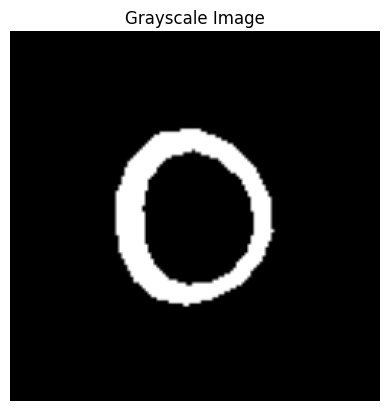

In [33]:
file_path ="data\\anatomicalSegmentations"
img = cv2.imread(file_path+'\\001.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')
plt.title("Grayscale Image")
plt.axis('off')  # Optional: hides axes
plt.show()

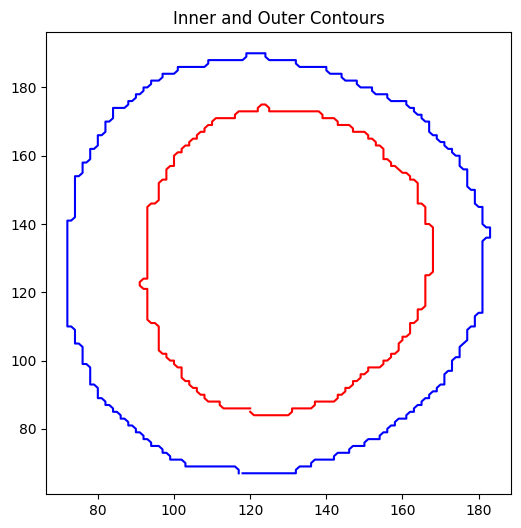

In [34]:
def get_contours(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    contours, _ = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    outer = contours[0][:, 0, :]  
    inner = contours[1][:, 0, :]  
    return outer, inner

outer,inner = get_contours(file_path+'\\001.png')
plt.figure(figsize=(6, 6))
plt.plot(outer[:, 0], outer[:, 1], label='Outer Contour', color='blue')
plt.plot(inner[:, 0], inner[:, 1], label='Inner Contour', color='red')
plt.title("Inner and Outer Contours")
plt.show()

In [35]:
def simple_resample_contour(contour, num_points=56):
    contour = contour.reshape(-1, 2).astype(np.float32)
    distances = np.sqrt(np.sum(np.diff(contour, axis=0)**2, axis=1))
    cumulative = np.insert(np.cumsum(distances), 0, 0)

    total_length = cumulative[-1]
    even_spaced = np.linspace(0, total_length, num_points)

    resampled = []
    for d in even_spaced:
        idx = np.searchsorted(cumulative, d)
        idx = min(idx, len(contour) - 2)
        t = (d - cumulative[idx]) / (cumulative[idx + 1] - cumulative[idx])
        pt = (1 - t) * contour[idx] + t * contour[idx + 1]
        resampled.append(pt)

    return np.array(resampled).T 


In [36]:
resampled_outer = simple_resample_contour(outer, num_points=56)
resampled_inner = simple_resample_contour(inner, num_points=56)

# Combine into a single shape
shape = np.hstack([resampled_outer, resampled_inner])  # shape: (2, 112)

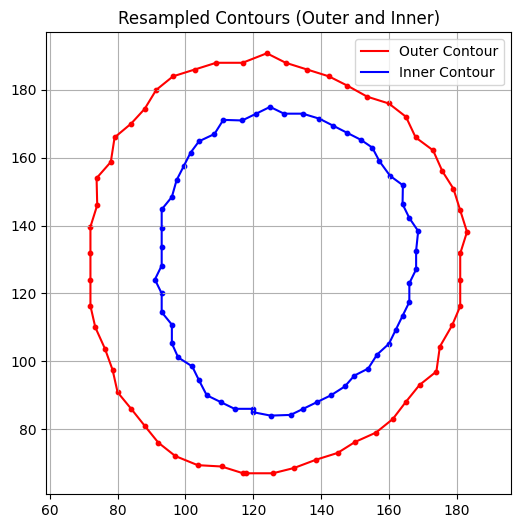

In [37]:
plt.figure(figsize=(6, 6))
plt.plot(resampled_outer[0], resampled_outer[1], 'r-', label='Outer Contour')
plt.plot(resampled_inner[0], resampled_inner[1], 'b-', label='Inner Contour')

# Optional: Add points to highlight samples
plt.scatter(resampled_outer[0], resampled_outer[1], color='red', s=10)
plt.scatter(resampled_inner[0], resampled_inner[1], color='blue', s=10)

plt.axis('equal')
plt.title('Resampled Contours (Outer and Inner)')
plt.legend()
plt.grid(True)
plt.show()


In [38]:
outer_pointsets=[]
inner_pointsets=[]
for file in os.listdir(file_path):
    if file.endswith(".png"):
        outer, inner = get_contours(os.path.join(file_path, file))
        if outer is not None and inner is not None:
            res_outer = simple_resample_contour(outer)
            res_inner = simple_resample_contour(inner)
            outer_pointsets.append(res_outer)
            inner_pointsets.append(res_inner)

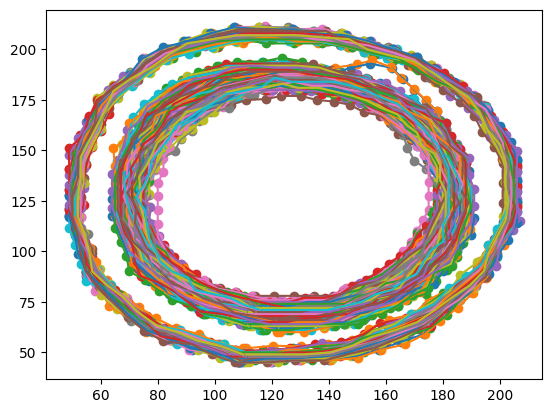

In [39]:
for i in range(150):
    plt.plot(outer_pointsets[i][0], outer_pointsets[i][1])
    plt.scatter(outer_pointsets[i][0], outer_pointsets[i][1])